<a href="https://colab.research.google.com/github/tososomaru/ml/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from fastai.vision import*
from fastai.metrics import error_rate
from torch.autograd import Variable
from torchvision import transforms, datasets

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Загрузка датасета

In [4]:
data_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')

In [5]:
data_train.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
data_test = pd.read_csv('/content/sample_data/mnist_test.csv')

In [7]:
data_test.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648,0.649,0.650,0.651,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Разделение меток и признаков

In [8]:
y_train, x_train = data_train['6'].values, (data_train.iloc[:,1:].values).astype('float32')
y_test, x_test = data_test['7'].values, (data_test.iloc[:,1:].values).astype('float32')

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19999, 784), (19999,), (9999, 784), (9999,))

#Изменение размерности признаков

In [10]:
x_train_img = x_train.reshape(x_train.shape[0], 28, 28)
x_test_img = x_test.reshape(x_test.shape[0], 28, 28)

In [11]:
x_train_img.shape

(19999, 28, 28)

#Визуализация тренирочовных данных

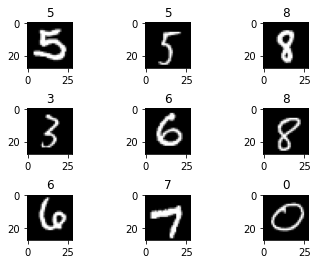

In [12]:
for i, img in enumerate(list(np.random.randint(0,19998, size=9))):
  plt.subplots_adjust(hspace=0.9)
  plt.subplot(3, 3, i+1)
  plt.imshow(x_train_img[img], cmap=plt.get_cmap('gray'))
  plt.title(y_train[img])

#Преобразование данных в тензоры

In [13]:
x_train_tensor = torch.tensor(x_train_img)/255.0
y_train_tensor = torch.tensor(y_train)

x_test_tensor = torch.tensor(x_test_img)/255.0
y_test_tensor = torch.tensor(y_test)

In [41]:
train_tensor = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, batch_size=64, num_workers=4, shuffle=True)

test_tensor = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_tensor, batch_size=16, num_workers=4, shuffle=False)

#Многослойный персептрон

In [19]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(784,250)
    self.bc1 = torch.nn.BatchNorm1d(250)

    self.fc2 = torch.nn.Linear(250,10)

  def forward(self, x):
    x = x.view((-1,784))
    x = self.fc1(x)
    x = self.bc1(x)
    x = torch.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)

    x = self.fc2(x)
    out = F.log_softmax(x)
    return out

model = Net()

#Выбор функции потерь и отптимизатора

In [20]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

#Обучение модели

In [21]:
for epoch in range(20):
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()

    output = model(data)

    loss = criterion(output, target)
    loss.backward()

    optimizer.step()

  print('Epoch: %s Loss: %s' %(epoch, loss.data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 Loss: tensor(0.9505)
Epoch: 1 Loss: tensor(0.3679)
Epoch: 2 Loss: tensor(0.3574)
Epoch: 3 Loss: tensor(0.1765)
Epoch: 4 Loss: tensor(0.1019)
Epoch: 5 Loss: tensor(0.4081)
Epoch: 6 Loss: tensor(0.0406)
Epoch: 7 Loss: tensor(0.9253)
Epoch: 8 Loss: tensor(0.0734)
Epoch: 9 Loss: tensor(0.2400)
Epoch: 10 Loss: tensor(0.4512)
Epoch: 11 Loss: tensor(0.0647)
Epoch: 12 Loss: tensor(0.1105)
Epoch: 13 Loss: tensor(0.0221)
Epoch: 14 Loss: tensor(0.0109)
Epoch: 15 Loss: tensor(0.0033)
Epoch: 16 Loss: tensor(0.1245)
Epoch: 17 Loss: tensor(0.2482)
Epoch: 18 Loss: tensor(0.0110)
Epoch: 19 Loss: tensor(0.0046)


#Точность модели на тестовых данных

In [22]:
data, target = test_tensor.tensors
output_test = model(data)
pred = output_test.data.max(1)[1]
eq = pred.eq(target.data)
a =(eq.sum().data.numpy())
b = eq.size()
b = torch.tensor(b)
b = (b.sum().data.numpy())
accuracy = a/b

print('Accuracy: {}/{} ({:.5f}%) '.format(a, b, accuracy) )

Accuracy: 9557/9999 (0.95580%) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


#Преобразование данных

In [51]:
y_train, x_train = data_train['6'].values, (data_train.iloc[:,1:].values).astype('float32')
y_test, x_test = data_test['7'].values, (data_test.iloc[:,1:].values).astype('float32')

In [52]:
x_train_img = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test_img = x_test.reshape(x_test.shape[0], 1, 28, 28)

In [53]:
x_train_img.shape

(19999, 1, 28, 28)

In [54]:
x_train_tensor = torch.tensor(x_train_img)/255.0
y_train_tensor = torch.tensor(y_train)

x_test_tensor = torch.tensor(x_test_img)/255.0
y_test_tensor = torch.tensor(y_test)

In [76]:
train_tensor = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, batch_size=128, num_workers=4, shuffle=True)

test_tensor = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_tensor, batch_size=128, num_workers=4, shuffle=False)

#Сверточная сеть

Размер карты активации после свёрточного слоя:

  \begin{eqnarray}
    W_{out} &=& \frac{W_{in}-F+2*P}{S}+1
  \end{eqnarray}

Где $K$ - число фильтров, $F$ - размер фильтра, $P$ - число доп. нулей, $S$ - шаг.


In [111]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5,  stride=1, padding=2), nn.ReLU(),
                                nn.MaxPool2d(2,2))
    self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), nn.ReLU(),
                                nn.MaxPool2d(2,2))
    self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), nn.ReLU(),
                                nn.MaxPool2d(2,2))

    self.fc1 = torch.nn.Linear(3*3*64, 500)
    self.fc2 = torch.nn.Linear(500,10)

  def forward(self, x):

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = torch.relu(x)

    x = self.fc2(x)
    out = F.log_softmax(x, dim=-1)
    return out

model = CNN()

#Выбор функции потерь и оптимизатора

In [112]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Обучение модели

In [113]:
for epoch in range(6):
  for batch_idx, (data, target) in enumerate(train_loader):
    
    data, target = Variable(data), Variable(target)

    optimizer.zero_grad()

    output = model(data)

    loss = criterion(output, target)
    loss.backward()

    optimizer.step()

  print('Epoch: %s Loss: %s' %(epoch, loss.data))

Epoch: 0 Loss: tensor(0.0775)
Epoch: 1 Loss: tensor(0.1689)
Epoch: 2 Loss: tensor(0.0178)
Epoch: 3 Loss: tensor(0.1544)
Epoch: 4 Loss: tensor(0.5116)
Epoch: 5 Loss: tensor(0.0023)


#Точность модели на тестовых данных

In [114]:
data, target = test_tensor.tensors
output_test = model(data)
pred = output_test.data.max(1)[1]
eq = pred.eq(target.data)
a =(eq.sum().data.numpy())
b = eq.size()
b = torch.tensor(b)
b = (b.sum().data.numpy())
accuracy = a/b

print('Accuracy: {}/{} ({:.5f}%) '.format(a, b, accuracy) )

Accuracy: 9873/9999 (0.98740%) 


In [137]:
param = list(model.named_parameters())

#Ядра первого светочного слоя

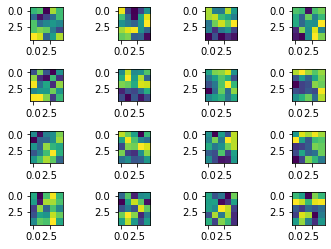

In [190]:
for i in range(16):
  plt.subplots_adjust(hspace=0.9)
  plt.subplot(4, 4, i+1)
  kernel = param[0][1][i].reshape([5,5]).detach().numpy()
  plt.imshow(kernel)